In [1]:
from __future__ import unicode_literals

import gtfs
import logging
from gtfs.entity import Trip, Route, StopTime
from sqlalchemy.sql import func
from sqlalchemy.orm import aliased
import networkx as nx
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import write_dot, graphviz_layout
import numpy as np

logging.basicConfig()
logging.getLogger('sqlalchemy.engine').setLevel(logging.WARN)

In [2]:
# Load up the transit data from the database for fast loading
#
# This data is from the RATP data site at https://data.ratp.fr/
sched = gtfs.Schedule("RATP.db")

In [3]:
# For each metro route, we get an example trip that we are going to use to get the station trip times -
# take a trip at around midday as that should have representative timings
metro_routes = sched.session.query(Route).filter(Route.route_type == 1).all()[8:10]
for route in metro_routes:
    # , [t for t in route.trips if 43200 <= t.stop_times[0].departure_time.val < 46800][0]
    route.example_trip = None

    for trip in route.trips:
        first_stop = sched.session.query(StopTime).filter(StopTime.trip_id == trip.trip_id).first()
        if 43200 <= first_stop.departure_time.val < 46800:
            route.example_trip = trip
            break

    print "{}: {} - {}".format(route.route_id, route.route_short_name, route.route_long_name)
    #print route.example_trip

1197630: 5 - (BOBIGNY - PABLO PICASSO <-> PLACE D'ITALIE) - Aller
1197631: 5 - (BOBIGNY - PABLO PICASSO <-> PLACE D'ITALIE) - Retour


In [4]:
# Create a graph to hold the stations, and add the travel times between them for each route
G = nx.MultiGraph()

for route in metro_routes:
    for from_st, to_st in zip(route.example_trip.stop_times[:-1], route.example_trip.stop_times[1:]):
        from_stop = from_st.stop
        to_stop = to_st.stop
        
        G.add_edge(from_stop, to_stop,
                   weight=float(to_st.elapsed_time - from_st.elapsed_time),
                   transfer=False)

# Note that the dataset treats the different platforms in a station as different stops
print G.degree()

[(<Stop 1951>, 2), (<Stop 1922>, 2), (<Stop 1746>, 2), (<Stop 2521>, 2), (<Stop 2072>, 2), (<Stop 2125>, 2), (<Stop 1932>, 2), (<Stop 2377>, 2), (<Stop 2382>, 2), (<Stop 1891>, 2), (<Stop 1675>, 2), (<Stop 2424>, 2), (<Stop 1898>, 2), (<Stop 2121>, 2), (<Stop 2297>, 2), (<Stop 2445>, 2), (<Stop 2437>, 2), (<Stop 2403>, 1), (<Stop 2112>, 2), (<Stop 2206>, 2), (<Stop 2076>, 2), (<Stop 2550>, 1), (<Stop 1767>, 2), (<Stop 2164>, 2), (<Stop 1901>, 2), (<Stop 1759>, 2), (<Stop 1793>, 1), (<Stop 2136>, 2), (<Stop 2257>, 2), (<Stop 2213>, 2), (<Stop 2294>, 2), (<Stop 1958>, 2), (<Stop 1772>, 2), (<Stop 2247>, 2), (<Stop 2063>, 2), (<Stop 2485>, 2), (<Stop 2008>, 2), (<Stop 1641>, 2), (<Stop 2310>, 2), (<Stop 1843>, 2), (<Stop 1700>, 2), (<Stop 2287>, 2), (<Stop 2089>, 1), (<Stop 2017>, 2)]


In [5]:
# Join together the different platforms using the travel time data
#
# The RATP data seems to be set up so that there are "bridging nodes"
# which can be transfered to from any point in the station, and every
# transfer has a minimum time attached to it. This will artificially
# inflate the time for transfers, which is probably what we want - we
# want to discourage changing trains in the final map
for node in sorted(G.nodes(), key=lambda x: x.stop_name):
    #print("{stop.stop_name} ({stop.stop_id}) -> "
    #      "{stop.location_type}:".format(stop=node))
    for transfer in node.transfers_away:
        if len(transfer.to_stop.transfers_away) == 0:
            #print("  ({stop.stop_id}) {stop.parent_station} " 
            #      "{stop.stop_name} - {transfer.transfer_type}: "
            #      "{transfer.min_transfer_time}"
            #      .format(transfer=transfer, stop=transfer.to_stop))
            G.add_edge(node, transfer.to_stop,
                       weight=float(transfer.min_transfer_time),
                       transfer=True)

print G.degree()

[(<Stop 3798449>, 2), (<Stop 4035563>, 2), (<Stop 2311>, 2), (<Stop 3798450>, 2), (<Stop 4035730>, 2), (<Stop 1772>, 4), (<Stop 2377>, 4), (<Stop 4035731>, 2), (<Stop 1700>, 2), (<Stop 2424>, 5), (<Stop 2550>, 3), (<Stop 2247>, 4), (<Stop 3764975>, 2), (<Stop 3747870>, 2), (<Stop 2294>, 3), (<Stop 4036859>, 2), (<Stop 2485>, 4), (<Stop 2297>, 4), (<Stop 4035817>, 2), (<Stop 7176294>, 2), (<Stop 2008>, 3), (<Stop 5747233>, 2), (<Stop 2089>, 3), (<Stop 2017>, 4), (<Stop 2287>, 4), (<Stop 2072>, 4), (<Stop 4037048>, 2), (<Stop 1759>, 2), (<Stop 5657279>, 2), (<Stop 1674>, 2), (<Stop 3764976>, 2), (<Stop 2527>, 2), (<Stop 2382>, 4), (<Stop 1767>, 4), (<Stop 1843>, 4), (<Stop 1793>, 4), (<Stop 4036786>, 2), (<Stop 2063>, 4), (<Stop 6682465>, 2), (<Stop 2111>, 2), (<Stop 5747225>, 2), (<Stop 5922192>, 2), (<Stop 3926304>, 2), (<Stop 3926433>, 2), (<Stop 5747219>, 2), (<Stop 2521>, 3), (<Stop 1932>, 7), (<Stop 1891>, 4), (<Stop 1675>, 4), (<Stop 3740297>, 2), (<Stop 6682464>, 2), (<Stop 2121>

In [6]:
# Get two key subgraphs:
# 1) The minimum spanning tree of the network (used to build the final output)
# 2) The disconnected "transfer" graph that contains an island for each station
#    that has transfers available in it (some stations are a single node)
T = nx.minimum_spanning_tree(G)
SG = nx.MultiGraph([(u, v, d) for u, v, d in G.edges(data=True) if d['transfer']])

print len(list(T.nodes()))
print nx.is_connected(T)

print len(list(SG.nodes()))
print nx.is_connected(SG)
print nx.number_connected_components(SG)

95
True
91
False
20


In [56]:
C = nx.condensation(T, scc=SG)

NetworkXNotImplemented: not implemented for undirected type

In [19]:
# Condense down all edges that are transitions
same_station = lambda u, v: (((u in SG) and (v in SG)) and 
                             u in nx.node_connected_component(SG, v))

Q = nx.quotient_graph(T, same_station)
Q.remove_edges_from([(n, n) for n in Q.nodes()])
print Q.degree()
print len(list(Q.nodes()))
print list(Q.nodes())[1]
print list(Q.neighbors(list(Q.nodes())[1]))
print type(Q)

[(frozenset([<Stop 3798450>, <Stop 2089>, <Stop 3798449>, <Stop 2550>]), 1), (frozenset([<Stop 1674>, <Stop 2484>, <Stop 2485>, <Stop 1675>]), 4), (frozenset([<Stop 2297>, <Stop 1901>, <Stop 5747225>, <Stop 5747226>]), 4), (frozenset([<Stop 2437>]), 2), (frozenset([<Stop 2377>, <Stop 2527>, <Stop 1767>, <Stop 1647>]), 3), (frozenset([<Stop 4044989>, <Stop 2294>, <Stop 1898>]), 3), (frozenset([<Stop 2403>, <Stop 4036786>, <Stop 1793>, <Stop 3926308>, <Stop 4036787>]), 2), (frozenset([<Stop 2521>, <Stop 3764975>, <Stop 1641>]), 4), (frozenset([<Stop 7176294>, <Stop 3764976>, <Stop 2206>, <Stop 1951>]), 4), (frozenset([<Stop 4035731>, <Stop 4035563>, <Stop 5747233>, <Stop 2125>, <Stop 4035730>, <Stop 2076>, <Stop 4037048>, <Stop 4035817>]), 3), (frozenset([<Stop 1700>]), 2), (frozenset([<Stop 2112>, <Stop 2063>, <Stop 2062>, <Stop 2111>]), 4), (frozenset([<Stop 2008>, <Stop 3747870>, <Stop 2164>]), 4), (frozenset([<Stop 1844>, <Stop 2310>, <Stop 1843>, <Stop 2311>]), 2), (frozenset([<Stop

(48.89546528048841, 2.426778609497494)
(48.892978636822406, 2.409396487205529)
(48.891454882127, 2.4023344067333996)
(48.888745693652176, 2.392545704807598)
(48.88695086167976, 2.386601947808809)
(48.8849316105461, 2.379091246899838)
(48.88287621621258, 2.3705863361654225)
(48.88418929420877, 2.367030441974567)
(48.878916395001, 2.353469578838293)
(48.875590451201234, 2.357692316387427)
(48.871114258986275, 2.3604834541826505)
(48.86761748653104, 2.3638195214331654)
(48.86497429063367, 2.36763241156394)
(48.860488412845775, 2.3719204375021397)
(48.856803948960916, 2.3705968196318707)
(48.85338911229207, 2.3691646022087665)
(48.84596603240645, 2.3669131797383116)
(48.84311767863822, 2.363997607036225)
(48.838516743515164, 2.360727550361784)
(48.83633304434552, 2.359256166042175)
(48.8312826555064, 2.3554558703645068)
(48.84596603240645, 2.3669131797383116)
(48.85338911229207, 2.3691646022087665)
(48.84596603240645, 2.3669131797383116)
(48.84311767863822, 2.363997607036225)
(48.838516743

RuntimeError: maximum recursion depth exceeded while calling a Python object

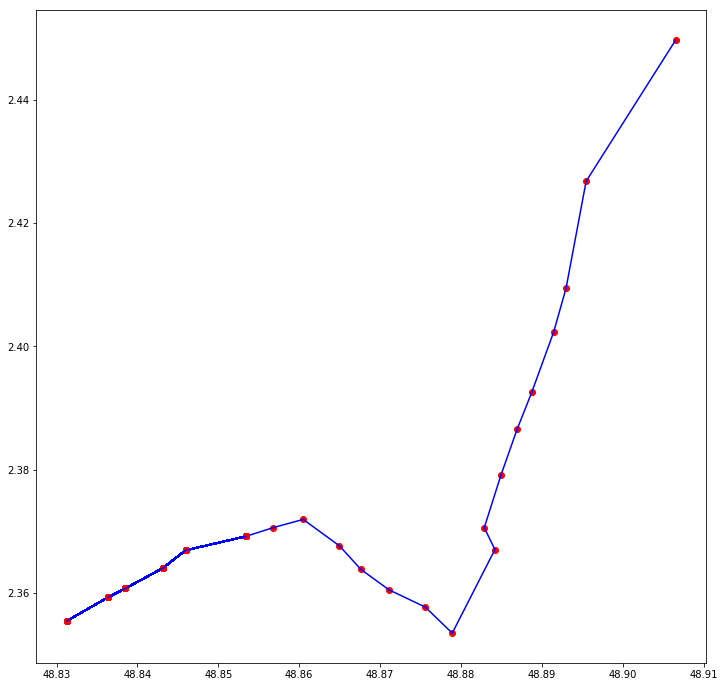

In [9]:
fig = plt.figure(figsize=(12,12))
axes = fig.add_subplot(111)

allowed_angles = np.linspace(0, 2 * np.pi, num=4, endpoint=False)
#print allowed_angles

root_node = list(Q.nodes())[0]
root_stop = next(iter(root_node))
#minx, miny = root.stop_lat, root.stop_lon
#maxx, maxy = root.stop_lat, root.stop_lon

axes.plot([root_stop.stop_lat,], [root_stop.stop_lon,], 'ro')

def print_tree(root, root_stop, parent_node=None, parent_stop=None):
    for neighbour in [n for n in nx.all_neighbors(Q, root)
                      if n not in [parent_node, root]]:
        neighbour_stop = next(iter(neighbour))
        print(neighbour_stop.stop_lat, neighbour_stop.stop_lon)
        axes.plot([neighbour_stop.stop_lat, ], [neighbour_stop.stop_lon, ], 'ro')
        axes.plot([root_stop.stop_lat, neighbour_stop.stop_lat],
                  [root_stop.stop_lon, neighbour_stop.stop_lon],
                  'b-')
        print_tree(neighbour, neighbour_stop, root, root_stop)

print_tree(root_node, root_stop)

In [19]:
list(G.nodes())[0] in G

True

In [4]:
# Check if trips always have the same stops on metro routes
for route in metro_routes:
    base_stops = [stop_time.stop.stop_name for stop_time in route.trips[0].stop_times]
    for idc, trip in enumerate(route.trips):
        stops = [stop_time.stop.stop_name for stop_time in trip.stop_times]
        assert len(stops) <= len(base_stops)
        if stops != base_stops:
            assert stops == base_stops[base_stops.index(stops[0]):base_stops.index(stops[0]) + len(stops)]
        #assert stops == base_stops, "{}: {} != {}".format(idc, stops, base_stops)

In [5]:
for route in metro_routes[-7:-5]:
    print "{}: {} - {}".format(route.route_id, route.route_short_name, route.route_long_name)
    print [stop_time.stop.stop_name for stop_time in route.trips[0].stop_times]
    #print (trip.service_period.start_date, trip.service_period.end_date)

for trip in metro_routes[-6].trips:
    print [stop_time.stop.stop_name for stop_time in trip.stop_times]

IndexError: list index out of range

In [6]:
# Build up a dictionary of neighbouring stop information
stops = {}

for route in metro_routes:
    if route.example_trip is None:
        continue

    for from_st, to_st in zip(route.example_trip.stop_times[:-1], route.example_trip.stop_times[1:]):
        from_stop = from_st.stop.stop_name
        to_stop = to_st.stop.stop_name
              
        if from_stop not in stops:
            stops[from_stop] = {}

        if to_stop not in stops[from_stop]:
            stops[from_stop][to_stop] = {}

        stops[from_stop][to_stop][route] = to_st.elapsed_time - from_st.elapsed_time
        

In [7]:
for key in stops.keys():
    print key

Hoche
Oberkampf
Quai de la Rapée
Ourcq
République
Richard-Lenoir
Saint-Marcel
Stalingrad
Bastille
Gare de l'Est (Verdun)
Gare du Nord
Eglise de Pantin
Bobigny-Pantin (Raymond Queneau)
Jacques-Bonsergent
Porte de Pantin
Bréguet-Sabin
Gare d'Austerlitz
Campo-Formio
Bobigny-Pablo-Picasso
Place d'Italie
Laumière
Jaurès


In [43]:
# Create a tree
root = stops.keys()[0]

G = nx.MultiGraph()
G.add_nodes_from(stops.keys())

max_trip_length = 0.0

for route in metro_routes:
    if route.example_trip is None:
        continue

    for from_st, to_st in zip(route.example_trip.stop_times[:-1], route.example_trip.stop_times[1:]):
        max_trip_length = max(max_trip_length, to_st.elapsed_time - from_st.elapsed_time)

print max_trip_length

for route in metro_routes:
    if route.example_trip is None:
        continue

    for from_st, to_st in zip(route.example_trip.stop_times[:-1], route.example_trip.stop_times[1:]):
        from_stop = from_st.stop.stop_name
        to_stop = to_st.stop.stop_name
              
        if from_stop not in stops:
            stops[from_stop] = {}

        if to_stop not in stops[from_stop]:
            stops[from_stop][to_stop] = {}

        G.add_edge(from_stop, to_stop, weight=float(to_st.elapsed_time - from_st.elapsed_time)/max_trip_length)

#def add_neighbours(stop):
#    for neighbour, routes in stops[stop].iteritems():
        

#for stop, ndict in stops.iteritems():
#    for n, routes in ndict.iteritems():
#        for route, time in routes.iteritems():
#            G.add_edge(stop, n, weight=time)

300


In [57]:
dir(list(G.nodes())[0])

['__class__',
 '__delattr__',
 '__dict__',
 '__doc__',
 '__format__',
 '__getattribute__',
 '__hash__',
 '__init__',
 '__mapper__',
 '__module__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__table__',
 '__tablename__',
 '__weakref__',
 '_decl_class_registry',
 '_sa_class_manager',
 '_sa_instance_state',
 'child_stations',
 'inbound_conversions',
 'location_type',
 'metadata',
 'parent',
 'parent_station',
 'query',
 'stop_code',
 'stop_desc',
 'stop_id',
 'stop_lat',
 'stop_lon',
 'stop_name',
 'stop_times',
 'stop_url',
 'transfers_away',
 'transfers_from',
 'zone_id']

(-0.9768555278019013,
 0.8869093537801671,
 -0.913991610267926,
 1.096529110053163)

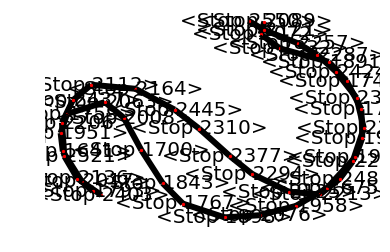

In [58]:
initial_pos = {node: (node.stop_lat, node.stop_lon) for node in G.nodes()}
pos=nx.spring_layout(G, pos=initial_pos) # positions for all nodes

# nodes
nx.draw_networkx_nodes(G,pos,node_size=5)

# edges
nx.draw_networkx_edges(G,pos,width=6)

# labels
nx.draw_networkx_labels(G,pos,font_size=20,font_family='sans-serif')

plt.axis('off')

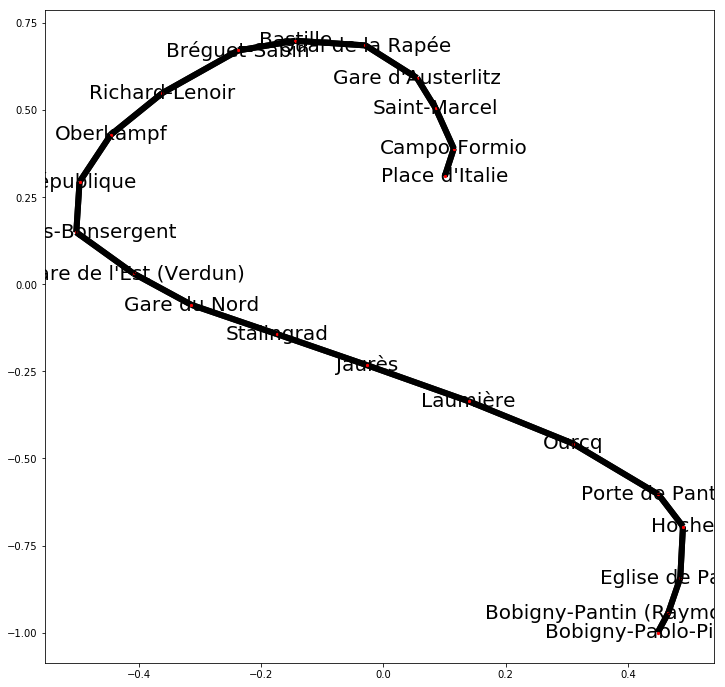

In [47]:
%matplotlib inline

fig = plt.figure(figsize=(12,12))
axes = fig.add_subplot(111)
#axes2 = fig.add_subplot(222)
pos=nx.spring_layout(G, k=0.01) # positions for all nodes

# nodes
nx.draw_networkx_nodes(G,pos,ax=axes,node_size=5)

# edges
nx.draw_networkx_edges(G,pos,ax=axes,width=6)

# labels
nx.draw_networkx_labels(G,pos,ax=axes,font_size=20,font_family='sans-serif')

#plt.axis('off')

#test = nx.minimum_spanning_tree(G)
#print len(test.edges())
#print len(G.edges())
#pos=graphviz_layout(test, prog='dot') # positions for all nodes

# nodes
#nx.draw(test, pos, ax=axes, node_size=5, with_labels=False, coloured_edges=test.edges())
#nx.draw_networkx(G, ax=axes, node_size=200, width=5)

# edges
#nx.draw_networkx_edges(G,ax=axes,width=6)

# labels
#nx.draw_networkx_labels(G,font_size=20,font_family='sans-serif')
fig.show()

In [31]:
metro_routes[0].trips[0].service_period.end_date

datetime.date(2018, 5, 21)

In [34]:
print [sp for sp in sched.service_periods if sp.tuesday]

[]


In [35]:
for trip in metro_routes[0].trips:
    print "{}: {} -> {} {}".format(trip.trip_id, trip.service_period.start_date.strftime("%Y-%m-%d"), trip.service_period.end_date.strftime("%Y-%m-%d"), trip.stop_times[0].departure_time)

24625337130912409: 2018-04-02 -> 2018-05-21 <Time 00:02:00>
24725337130912409: 2018-04-02 -> 2018-05-21 <Time 00:06:00>
24825337130912409: 2018-04-02 -> 2018-05-21 <Time 00:10:00>
24925337130912409: 2018-04-02 -> 2018-05-21 <Time 00:14:00>
25025337130912409: 2018-04-02 -> 2018-05-21 <Time 00:18:00>
25125337130912409: 2018-04-02 -> 2018-05-21 <Time 00:22:00>
25225337130912409: 2018-04-02 -> 2018-05-21 <Time 00:26:00>
25325337130912409: 2018-04-02 -> 2018-05-21 <Time 00:30:00>
25425337130912409: 2018-04-02 -> 2018-05-21 <Time 00:34:00>
25525337130912409: 2018-04-02 -> 2018-05-21 <Time 00:38:00>
25625337130912409: 2018-04-02 -> 2018-05-21 <Time 00:42:00>
25725337130912409: 2018-04-02 -> 2018-05-21 <Time 00:46:00>
25825337130912409: 2018-04-02 -> 2018-05-21 <Time 00:50:00>
25925337130912409: 2018-04-02 -> 2018-05-21 <Time 00:55:00>
26025337130912409: 2018-04-02 -> 2018-05-21 <Time 01:02:00>
26125337130912409: 2018-04-02 -> 2018-05-21 <Time 01:11:00>
26225337130912409: 2018-04-02 -> 2018-05

In [36]:
print set(t.service_period.service_id for t in metro_routes[0].trips)

set([u'12533714', u'12533715', u'12533717', u'2533725', u'2533724', u'12533713', u'12533718', u'12533719', u'2533721', u'2533720', u'2533722', u'12533725', u'12533724', u'12533721', u'12533720', u'12533722', u'2533714', u'2533715', u'2533717', u'2533713', u'2533718', u'2533719'])


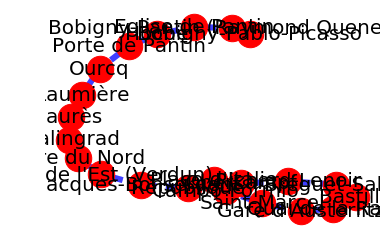

In [45]:
# Author: Aric Hagberg (hagberg@lanl.gov)
import matplotlib.pyplot as plt
import networkx as nx

#G = nx.Graph()

#G.add_edge('a', 'b', weight=0.6)
#G.add_edge('a', 'c', weight=0.2)
#G.add_edge('c', 'd', weight=0.1)
#G.add_edge('c', 'e', weight=0.7)
#G.add_edge('c', 'f', weight=0.9)
#G.add_edge('a', 'd', weight=0.3)

elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] > 0.5]
esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] <= 0.5]

pos = nx.spring_layout(G)  # positions for all nodes

# nodes
nx.draw_networkx_nodes(G, pos, node_size=700)

# edges
nx.draw_networkx_edges(G, pos, edgelist=elarge,
                       width=6)
nx.draw_networkx_edges(G, pos, edgelist=esmall,
                       width=6, alpha=0.5, edge_color='b', style='dashed')

# labels
nx.draw_networkx_labels(G, pos, font_size=20, font_family='sans-serif')

plt.axis('off')
plt.show()

In [44]:
print [e[2]["weight"] for e in G.edges(data=True)]

[0.4, 0.4, 0.2, 0.4, 0.2, 0.4, 0.4, 0.2, 0.4, 0.4, 0.2, 0.4, 0.2, 0.2, 0.4, 0.2, 0.2, 0.4, 0.2, 0.2, 0.4, 0.2, 0.2, 0.2, 0.4, 0.4, 0.2, 0.4, 0.4, 0.2, 0.4, 0.4, 0.4, 0.2, 0.4, 0.2, 0.8, 1.0, 0.2, 0.2, 0.6, 0.4]


In [31]:
dir(G)

['__class__',
 '__contains__',
 '__delattr__',
 '__dict__',
 '__doc__',
 '__format__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__hash__',
 '__init__',
 '__iter__',
 '__len__',
 '__module__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_adj',
 '_node',
 'add_cycle',
 'add_edge',
 'add_edges_from',
 'add_node',
 'add_nodes_from',
 'add_path',
 'add_star',
 'add_weighted_edges_from',
 'adj',
 'adjacency',
 'adjlist_inner_dict_factory',
 'adjlist_outer_dict_factory',
 'clear',
 'copy',
 'degree',
 'edge_attr_dict_factory',
 'edge_key_dict_factory',
 'edge_subgraph',
 'edges',
 'fresh_copy',
 'get_edge_data',
 'graph',
 'has_edge',
 'has_node',
 'is_directed',
 'is_multigraph',
 'name',
 'nbunch_iter',
 'neighbors',
 'new_edge_key',
 'node',
 'node_dict_factory',
 'nodes',
 'nodes_with_selfloops',
 'number_of_edges',
 'number_of_nodes',
 'number_of_selfloops',
 'order',
 'remove_e